# Milestone P3

# Milestone Objectives

- Execute the project: single final notebook (main logic), helpers python file (implementations functions).

- Write a data story

- Update README: details the contributions of all group members.

[Milestone P3 briefing](https://epfl-ada.github.io/teaching/fall2023/cs401/projects/#p3-final-project-and-the-datastory)

In [3]:
import os
from helpers import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from implementations import *

import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

os.environ['PYARROW_IGNORE_TIMEZONE'] = '1'


In [ ]:
%run ./milestoneP2.ipynb

In [4]:
display(movies2_clean.sample(5))
display(movies2_clean.shape)
display(movies2_clean.info())

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part
2796,4220121,/m/0bqnt_,The Condemned,2007,114.0,"[German Language, English Language, Spanish La...",[USA],"[Thriller, Action, Escape Film]",NaN,NaN,8642858.0,0.000447
3008,3069423,/m/08pb5v,Corvette Summer,1978,105.0,[English Language],[USA],"[Romantic comedy, Adventure, Screwball comedy,...",5.500000,16.0,15500000.0,0.006964
6873,1409665,/m/04_73f,Bowfinger,1999,97.0,[English Language],[USA],"[Comedy of Errors, Comedy]",6.400000,68000.0,98625775.0,0.00759
5983,928529,/m/03qtpl,Anacondas: The Hunt for the Blood Orchid,2004,96.0,[English Language],[USA],"[Thriller, Natural horror films, Horror, Adven...",NaN,NaN,70992898.0,0.004204
4941,1107070,/m/046kxx,Police Academy 2: Their First Assignment,1985,87.0,[English Language],[USA],"[Action/Adventure, Action, Comedy, Slapstick]",5.798692,53349.0,55600000.0,0.015206


(7285, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_wiki       7285 non-null   int64  
 1   id_freebase   7285 non-null   object 
 2   name          7285 non-null   object 
 3   year          7285 non-null   int32  
 4   runtime       7260 non-null   float64
 5   lang          7285 non-null   object 
 6   countries     7285 non-null   object 
 7   genres        7285 non-null   object 
 8   review        2898 non-null   float64
 9   nbr_review    2898 non-null   float64
 10  revenue       7285 non-null   object 
 11  revenue_part  7285 non-null   object 
dtypes: float64(3), int32(1), int64(1), object(7)
memory usage: 654.6+ KB


None

## 0) Overview of the data used 

## 1) Finding Potential pivotal movies

In this section, we will first analyze trends in specific genres of movies, focusing on those that are more niche and specific, such as Science Fiction, Teen, and Biography. The objective is to uncover patterns and insights within these specialized genres, as opposed to broader categories like Action or Adventure.

After obtaining the trends we could be able to identify, for each trend, a subset of movies that could have strat the trend (i.e. pivotal movies)

### a) Selection of niches genre

### b) Trend graphs for some genres


### c) Trend automatic detection

### d) Construction of potential pivotal movie sets 
 

## 2) Metric assessment for Pivotal Movies identification

Identifying the pivotal movie, or the one that starts a trend, involves a combination of qualitative and quantitative analysis. Here are considerations and steps to help define the chosen pivotal movie within a specific genre:

 - **Box-office Revenue :**
    Analyze the box-office performance of candidate movies within the subset. The pivotal movie often exhibits exceptional financial success, indicating a strong audience demand for the particular genre or theme. We need then to look for movies that surpassed industry expectations in terms of revenue. Also comparing the box-office performance of candidate movies to industry standards and consider their impact on subsequent films' budgeting and revenue expectations.

- **Reviews :**
   Critical reception is a key indicator of a movie's impact and lasting influence. The pivotal movie should have received positive reviews from both critics and audiences, showcasing its quality and appeal. To this aims we incorporate a new dataset that includes review. These review will be a measuremnent of how good a movie is . This metric is fundamental to identify the pivotal movie : if a film is considered as bad there is no chance that it influence the cinema industry and creating a trend.

- **Awards :**
Another measure for assessing influence is the recognition garnered through awards. Industry accolades serve as a validation of a movie's cultural and artistic significance. The receipt of awards signifies not only the excellence of the film but also its potential to set a standard worth emulating. It provides more precise insights into why the film is esteemed. Noteworthy awards include prestigious honors like the Oscars or Golden Globes. In our analysis, we have opted to incorporate a dataset that encompasses these awards and their respective categories.

- **Plot Similarity:**
  This metric serves as an assessment of the extent to which a film influences others within the genre during trends. The concept is as follows: if the plot of a potential pivotal film closely resembles those observed in subsequent trend films when compared to other movies in the candidate subset, it indicates the film's influence on plot development. This similarity suggests that other films intentionally emulated the storyline, signifying the impactful nature of the pivotal film.



All these metrics will be exploited to select the pivotal film among the candidate subset. But to use it we need to properly define function which calculate from available data or simply add missing data from other dataset.


### a) Box-office revenue

### b) Reviews

### c) Awards

### d) Plot similarity

## 3) Method for identifying pivotal movies

### a) Method 1 : Machine learning

In this subsection we aim to identify the

### b) (TO COMPLETE)

## 4) Analysis of the results 

We finally got the set of pivotals movies but we need to do an assessment of these results. 

### a) Convergence of the methods

### b) Correlation between pivotal movies

### c) How to make a pivotal movie ?

## MEHDI

In [5]:
# Pre merge df of m2:

display(movies.sample(5))
display(movies.shape)
display(movies.info())

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
52612,8979709,/m/027s2rh,Applause,1929,NaN,79.0,[English Language],[USA],"[Drama, Musical, Pre-Code, Black-and-white]"
63369,4616833,/m/0ccw9s,Ernest in the Army,1998,NaN,90.0,[English Language],[USA],"[Parody, Family Film, Comedy, Slapstick]"
64598,4390109,/m/0b_prc,Genie Magic,2006,NaN,66.0,[English Language],[USA],"[Children's, Fantasy, Comedy, Animation]"
74268,454208,/m/02bg55,The Butterfly Effect,2004,96060858.0,120.0,[English Language],"[USA, Canada]","[Thriller, Science Fiction, Time travel, Psych..."
69794,226515,/m/01h0t5,Jason and the Argonauts,1963,NaN,104.0,[English Language],"[USA, United Kingdom]","[Adventure, Stop motion, Costume drama, Action..."


(29828, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 29828 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      29828 non-null  int64  
 1   id_freebase  29828 non-null  object 
 2   name         29828 non-null  object 
 3   year         29828 non-null  int32  
 4   revenue      6779 non-null   float64
 5   runtime      26436 non-null  float64
 6   lang         29828 non-null  object 
 7   countries    29828 non-null  object 
 8   genres       29828 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 2.2+ MB


None

In [6]:
CHARACTERS_DATASET = MOVIES_FOLDER + 'character.metadata.tsv'
char_df = pd.read_csv(CHARACTERS_DATASET, sep='\t', encoding='utf-8', names=['id_wiki','id_freebase', 'year', 'char_name', 'actor_DOB', 'actor_gender',
                                                                              'actor_height', 'actor_ethn', 'actor_name', 'actor_age', 'freebase_map'])


display(char_df.sample(5))
display(char_df.shape)
display(char_df.info())

,,id_wiki,id_freebase,year,char_name,actor_DOB,actor_gender,actor_height,actor_ethn,actor_name,actor_age,freebase_map
24480838,/m/09k56b7,2010-09-01,Galina,1979-10-30,F,1.63,NaN,Kristina Anapau,30.0,/m/0cl3yqx,/m/0fq9hb2,/m/0959my
2008863,/m/06dq4r,2005-09-22,Fiona,1982-08-19,F,1.65,/m/06gbnc,Erika Christensen,23.0,/m/0jy9mf,/m/0h2nr2m,/m/04smkr
1592736,/m/05f1t6,2003,Seth,1977-10-26,M,1.85,NaN,Jon Heder,25.0,/m/0k1tfm,/m/0h2qhb_,/m/04stzk
1265864,/m/04ngxk,1996-11-01,NaN,1943-12-07,F,NaN,NaN,Sue Johnston,52.0,/m/0cg0h7t,NaN,/m/06h_4c
1973137,/m/06b36w,2003,NaN,1978-10-21,F,NaN,NaN,Sangeetha,24.0,/m/02vbmy_,NaN,/m/026m_gk


(450669, 11)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 450669 entries, (975900, '/m/03vyhn') to (28308153, '/m/0cp05t9')
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id_wiki       440674 non-null  object 
 1   id_freebase   192794 non-null  object 
 2   year          344524 non-null  object 
 3   char_name     405060 non-null  object 
 4   actor_DOB     154824 non-null  float64
 5   actor_gender  106058 non-null  object 
 6   actor_height  449441 non-null  object 
 7   actor_ethn    292556 non-null  float64
 8   actor_name    450669 non-null  object 
 9   actor_age     192804 non-null  object 
 10  freebase_map  449854 non-null  object 
dtypes: float64(2), object(9)
memory usage: 46.3+ MB


None

# Wiki Award dataset

In [18]:
DATA_PATH = '../data'
WIKI_AWARD_PATH = '/awardsWiki/oscar.csv'

In [19]:
wiki_awards = pd.read_csv(DATA_PATH+WIKI_AWARD_PATH)
display(wiki_awards.sample(5))
display(wiki_awards.shape)
display(wiki_awards.info())

,Unnamed: 0,Film,Year,Award,Nomination
215,215,Smile Pinki,2008,1,1
443,443,Indochine,1992,1,2
897,897,The Cat Concerto,1946,1,1
1325,1325,Watch on the Rhine,1943,1,4
39,39,My Octopus Teacher,21,1,1


(1360, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360 entries, 0 to 1359
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1360 non-null   int64 
 1   Film        1359 non-null   object
 2   Year        1360 non-null   int64 
 3   Award       1360 non-null   int64 
 4   Nomination  1360 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 53.2+ KB


None

In [22]:
display(wiki_awards[wiki_awards['Award']==0])
display(wiki_awards[wiki_awards['Film']=='Star Wars'])
display(wiki_awards[wiki_awards['Film'].str.contains('Star Wars', case=False, na=False)])

,Unnamed: 0,Film,Year,Award,Nomination
407,407,Toy Story,1995,0,3
477,477,Total Recall,1990,0,2
521,521,RoboCop,1987,0,2
565,565,The River,1984,0,4
577,577,Return of the Jedi,1983,0,4
627,627,The Black Stallion,1979,0,2
642,642,Superman,1978,0,3
667,667,King Kong,1976,0,2
668,668,Logan's Run,1976,0,2
681,681,The Hindenburg,1975,0,3


,Unnamed: 0,Film,Year,Award,Nomination
644,644,Star Wars,1977,6,10


,Unnamed: 0,Film,Year,Award,Nomination
644,644,Star Wars,1977,6,10


# Award dataset

In [7]:
DATA_PATH = '../data'
AWARDS_PATH = '/awards/oscars.csv'

In [8]:
awards = pd.read_csv(DATA_PATH+AWARDS_PATH).rename(columns={'year_film': 'year', 'category': 'cat_nominated', 'name': 'name_nominated', 'film': 'name'})
display(awards.sample(5))
display(awards.shape)
display(awards.info())

,year,year_ceremony,ceremony,cat_nominated,name_nominated,name,winner
4509,1967,1968,40,FOREIGN LANGUAGE FILM,France,Live for Life,False
1428,1942,1943,15,SPECIAL EFFECTS,Photographic Effects by Byron Haskin; Sound Ef...,Desperate Journey,False
5683,1978,1979,51,MUSIC (Original Score),Dave Grusin,Heaven Can Wait,False
10266,2018,2019,91,IRVING G. THALBERG MEMORIAL AWARD,Kathleen Kennedy and Frank Marshall,NaN,True
5806,1979,1980,52,SHORT FILM (Live Action),"Roman Kroitor and Stefan Wodoslawsky, Producers",Bravery in the Field,False


(10765, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10765 entries, 0 to 10764
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            10765 non-null  int64 
 1   year_ceremony   10765 non-null  int64 
 2   ceremony        10765 non-null  int64 
 3   cat_nominated   10765 non-null  object
 4   name_nominated  10761 non-null  object
 5   name            10450 non-null  object
 6   winner          10765 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 515.2+ KB


None

In [9]:
# Get rid of missing name rows

awards_clean = awards.copy()
awards_clean = awards.loc[~awards['name'].isna()].reset_index(drop=True)
display(awards_clean.sample(5))
display(awards_clean.shape)
display(awards_clean.info())

,year,year_ceremony,ceremony,cat_nominated,name_nominated,name,winner
4120,1965,1966,38,FOREIGN LANGUAGE FILM,Japan,Kwaidan,False
5280,1976,1977,49,MUSIC (Original Score),Jerry Fielding,The Outlaw Josey Wales,False
6929,1992,1993,65,FILM EDITING,Geraldine Peroni,The Player,False
621,1938,1939,11,ACTRESS IN A SUPPORTING ROLE,Spring Byington,You Can't Take It with You,False
1059,1941,1942,14,CINEMATOGRAPHY (Black-and-White),Karl Freund,The Chocolate Soldier,False


(10450, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year            10450 non-null  int64 
 1   year_ceremony   10450 non-null  int64 
 2   ceremony        10450 non-null  int64 
 3   cat_nominated   10450 non-null  object
 4   name_nominated  10450 non-null  object
 5   name            10450 non-null  object
 6   winner          10450 non-null  bool  
dtypes: bool(1), int64(3), object(3)
memory usage: 500.2+ KB


None

In [10]:
generate_missing_info(awards_clean)

,Missing Data (%)
Column,
year,0.0
year_ceremony,0.0
ceremony,0.0
cat_nominated,0.0
name_nominated,0.0
name,0.0
winner,0.0


In [11]:
awards_clean.cat_nominated.unique()

array(['ACTOR', 'ACTRESS', 'ART DIRECTION', 'CINEMATOGRAPHY',
       'DIRECTING (Comedy Picture)', 'DIRECTING (Dramatic Picture)',
       'ENGINEERING EFFECTS', 'OUTSTANDING PICTURE',
       'UNIQUE AND ARTISTIC PICTURE', 'WRITING (Adaptation)',
       'WRITING (Original Story)', 'WRITING (Title Writing)', 'DIRECTING',
       'WRITING', 'OUTSTANDING PRODUCTION', 'SOUND RECORDING',
       'SHORT SUBJECT (Cartoon)', 'SHORT SUBJECT (Comedy)',
       'SHORT SUBJECT (Novelty)', 'ASSISTANT DIRECTOR', 'FILM EDITING',
       'MUSIC (Scoring)', 'MUSIC (Song)', 'DANCE DIRECTION',
       'WRITING (Screenplay)', 'ACTOR IN A SUPPORTING ROLE',
       'ACTRESS IN A SUPPORTING ROLE', 'SHORT SUBJECT (Color)',
       'SHORT SUBJECT (One-reel)', 'SHORT SUBJECT (Two-reel)',
       'MUSIC (Original Score)', 'CINEMATOGRAPHY (Black-and-White)',
       'CINEMATOGRAPHY (Color)', 'SPECIAL EFFECTS',
       'ART DIRECTION (Black-and-White)', 'ART DIRECTION (Color)',
       'WRITING (Original Screenplay)', 'DOCUME

In [12]:
check_doublons(awards_clean, ['name'], 'year', 'ceremony')

Rows with real duplicates: 
                                    name  year  ceremony
1                       The Last Command  1927         1
3                             7th Heaven  1927         1
5                                Sunrise  1927         1
7                             7th Heaven  1927         1
9                                Sunrise  1927         1
...                                  ...   ...       ...
10444          The Banshees of Inisherin  2022        95
10445  Everything Everywhere All at Once  2022        95
10446                      The Fabelmans  2022        95
10447                                Tár  2022        95
10448                Triangle of Sadness  2022        95

[7020 rows x 3 columns]
--------------------------------------------------------------------------------


In [13]:
awards_clean[awards_clean['name']=='7th Heaven']
awards_clean[awards_clean['name'].str.contains('Star Wars', case=False, na=False)]

,year,year_ceremony,ceremony,cat_nominated,name_nominated,name,winner
5328,1977,1978,50,ACTOR IN A SUPPORTING ROLE,Alec Guinness,Star Wars,False
5344,1977,1978,50,ART DIRECTION,"Art Direction: John Barry, Norman Reynolds, L...",Star Wars,True
5355,1977,1978,50,COSTUME DESIGN,John Mollo,Star Wars,True
5359,1977,1978,50,DIRECTING,George Lucas,Star Wars,False
5374,1977,1978,50,FILM EDITING,"Paul Hirsch, Marcia Lucas, Richard Chew",Star Wars,True
5385,1977,1978,50,MUSIC (Original Score),John Williams,Star Wars,True
5397,1977,1978,50,BEST PICTURE,"Gary Kurtz, Producer",Star Wars,False
5411,1977,1978,50,SOUND,"Don MacDougall, Ray West, Bob Minkler, Derek Ball",Star Wars,True
5414,1977,1978,50,VISUAL EFFECTS,"John Stears, John Dykstra, Richard Edlund, Gra...",Star Wars,True
5423,1977,1978,50,WRITING (Screenplay Written Directly for the S...,George Lucas,Star Wars,False


In [14]:
awards_condensed = awards_clean.copy()
aggregation_functions = {
    'year': 'first',
    'year_ceremony': 'first',
    'ceremony': 'first',
    'cat_nominated': list,
    'name_nominated': list,
    'winner': list
}

awards_condensed = awards_clean.groupby('name').agg(aggregation_functions).reset_index()

display(awards_condensed.sample(5))
display(awards_condensed.shape)
display(awards_condensed.info())

,name,year,year_ceremony,ceremony,cat_nominated,name_nominated,winner
2802,Rasputin and the Empress,1932,1933,6,[WRITING (Original Story)],[Charles MacArthur],[False]
927,Culture,1998,1999,71,[SHORT FILM (Live Action)],"[Will Speck, Josh Gordon]",[False]
3044,Silence,2016,2017,89,[CINEMATOGRAPHY],[Rodrigo Prieto],[False]
1448,Good-bye Miss Turlock,1947,1948,20,[SHORT SUBJECT (One-reel)],"[Herbert Moulton, Producer]",[True]
3086,Smart Money,1930,1931,4,[WRITING (Original Story)],"[Lucien Hubbard, Joseph Jackson]",[False]


(4991, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4991 entries, 0 to 4990
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   name            4991 non-null   object
 1   year            4991 non-null   int64 
 2   year_ceremony   4991 non-null   int64 
 3   ceremony        4991 non-null   int64 
 4   cat_nominated   4991 non-null   object
 5   name_nominated  4991 non-null   object
 6   winner          4991 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.1+ KB


None

In [15]:
awards_condensed[awards_condensed['name']=='Star Wars']

,name,year,year_ceremony,ceremony,cat_nominated,name_nominated,winner
3197,Star Wars,1977,1978,50,"[ACTOR IN A SUPPORTING ROLE, ART DIRECTION, CO...","[Alec Guinness, Art Direction: John Barry, No...","[False, True, True, False, True, True, False, ..."


In [16]:
# Problemo grando:

display(awards_condensed[awards_condensed['name'].str.contains('Star Wars', case=False, na=False)])
display(movies[movies['name'].str.contains('Star Wars', case=False, na=False)])

# Option 1: remove ponctuation from every name (DOES NOT WORK Star Wars vs Star Wars Episode IV: A New Hope)
# Option 2: use as merge key the producer name + year. Need character.csv

,name,year,year_ceremony,ceremony,cat_nominated,name_nominated,winner
2883,Rogue One: A Star Wars Story,2016,2017,89,"[SOUND MIXING, VISUAL EFFECTS]","[David Parker, Christopher Scarabosio and Stua...","[False, False]"
3112,Solo: A Star Wars Story,2018,2019,91,[VISUAL EFFECTS],"[Rob Bredow, Patrick Tubach, Neal Scanlan and ...",[False]
3197,Star Wars,1977,1978,50,"[ACTOR IN A SUPPORTING ROLE, ART DIRECTION, CO...","[Alec Guinness, Art Direction: John Barry, No...","[False, True, True, False, True, True, False, ..."
3198,Star Wars Episode I: The Phantom Menace,1999,2000,72,"[SOUND, SOUND EFFECTS EDITING, VISUAL EFFECTS]","[Gary Rydstrom, Tom Johnson, Shawn Murphy, Joh...","[False, False, False]"
3199,Star Wars Episode II Attack of the Clones,2002,2003,75,[VISUAL EFFECTS],"[Rob Coleman, Pablo Helman, John Knoll, Ben Snow]",[False]
3200,Star Wars: Episode III Revenge of the Sith,2005,2006,78,[MAKEUP],[Dave Elsey and Nikki Gooley],[False]
3201,Star Wars: The Force Awakens,2015,2016,88,"[FILM EDITING, MUSIC (Original Score), SOUND E...","[Maryann Brandon and Mary Jo Markey, John Will...","[False, False, False, False, False]"
3202,Star Wars: The Last Jedi,2017,2018,90,"[MUSIC (Original Score), SOUND EDITING, SOUND ...","[John Williams, Matthew Wood and Ren Klyce, Da...","[False, False, False, False]"
3203,Star Wars: The Rise of Skywalker,2019,2020,92,"[MUSIC (Original Score), SOUND EDITING, VISUAL...","[John Williams, Matthew Wood and David Acord, ...","[False, False, False]"


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
4355,15726696,/m/0cpllql,Star Wars: The Clone Wars,2008,6.828284e+07,90.0,[English Language],[USA],"[Thriller, Science Fiction, Adventure, Compute..."
5454,50957,/m/0dfw0,Star Wars Episode II: Attack of the Clones,2002,6.493983e+08,142.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
8240,1861566,/m/061wqh,Saving Star Wars,2004,NaN,117.0,[English Language],[USA],"[Indie, Comedy]"
14376,50744,/m/0ddjy,Star Wars Episode VI: Return of the Jedi,1983,4.751062e+08,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
28976,3336298,/m/096gqt,The Making of Star Wars,1977,NaN,50.0,[English Language],[USA],[Documentary]
45820,50793,/m/0ddt_,Star Wars Episode I: The Phantom Menace,1999,1.027045e+09,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ..."
51167,53964,/m/0f3m1,Star Wars Episode V: The Empire Strikes Back,1980,5.383751e+08,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."
51391,185264,/m/0199wf,The Star Wars Holiday Special,1978,NaN,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani..."
57081,55447,/m/0fdv3,Star Wars Episode III: Revenge of the Sith,2005,8.487548e+08,140.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Tragedy, Ad..."
62252,1823554,/m/05zsyv,Star Wars: Revelations,2005,NaN,47.0,[English Language],[USA],"[Fan film, Indie]"


(array([274., 696., 569., 472., 478., 430., 501., 480., 543., 548.]),
 array([1927. , 1936.5, 1946. , 1955.5, 1965. , 1974.5, 1984. , 1993.5,
        2003. , 2012.5, 2022. ]),
 [<matplotlib.patches.Polygon at 0x1f8917ce9a0>])

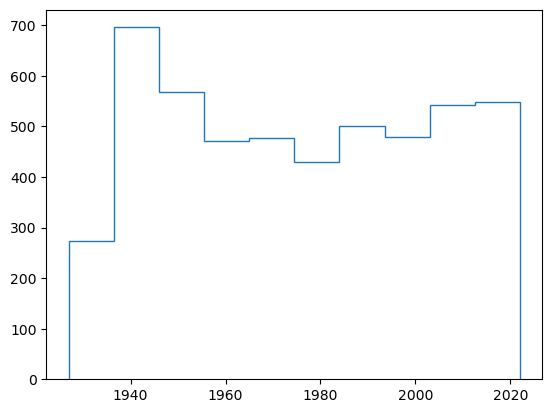

In [17]:
plt.hist(awards_condensed.year, histtype='step') 

# Trying to get more ratings 

In [18]:
BIG_RATINGS_PATH = '/ml-latest/ratings.csv'

In [26]:
spark = SparkSession.builder.appName("Ratings").getOrCreate()
big_ratings = spark.read.csv(DATA_PATH+BIG_RATINGS_PATH, header=True, inferSchema=True)
big_ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      1|   4.0|1225734739|
|     1|    110|   4.0|1225865086|
|     1|    158|   4.0|1225733503|
|     1|    260|   4.5|1225735204|
|     1|    356|   5.0|1225735119|
+------+-------+------+----------+
only showing top 5 rows



In [27]:
big_ratings_clean = big_ratings.groupBy("movieId").agg(
    F.avg("rating").alias("average_rating"),
    F.count("rating").alias("nbr_ratings")
)

big_ratings_clean.show()

+-------+------------------+-----------+
|movieId|    average_rating|nbr_ratings|
+-------+------------------+-----------+
|   1959| 3.633800573431029|       6278|
|   1591|2.6484306887532694|       6882|
|   1580| 3.595333426758223|      49951|
|   1645|  3.56697669143084|      17633|
|  44022|3.2430483271375463|       6725|
|   3175| 3.602825957745718|      18507|
|  32460|4.0208131655372705|       1033|
| 280218|3.4652701212789414|        907|
|    148|               2.9|        380|
|    471| 3.651588858375834|      12745|
|   8638| 4.005075757575757|       6600|
|  96488| 3.993886230728336|       1881|
|    496|3.3140877598152425|        433|
|   1088| 3.274450709702508|      15429|
|   2366|3.4753840782122905|       8592|
|   3918| 3.014236902050114|       1756|
|   1342|  3.02922642329422|       4602|
|  54190| 3.552968186290587|       3049|
|   7833| 3.819178082191781|        365|
|  31983|           3.53125|         48|
+-------+------------------+-----------+
only showing top

In [29]:
num_rows = big_ratings_clean.count()
num_columns = len(big_ratings_clean.columns)
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 83239
Number of columns: 3


In [30]:
big_ratings_pd = big_ratings_clean.toPandas()
display(big_ratings_pd.sample(5))
display(big_ratings_pd.shape)
display(big_ratings_pd.info())

,movieId,average_rating,nbr_ratings
81013,208685,3.000000,1
77548,130271,2.600000,5
57113,121374,4.008811,227
4415,271232,2.901728,463
34888,86766,4.000000,7


(83239, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83239 entries, 0 to 83238
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movieId         83239 non-null  int32  
 1   average_rating  83239 non-null  float64
 2   nbr_ratings     83239 non-null  int64  
dtypes: float64(1), int32(1), int64(1)
memory usage: 1.6 MB


None

## Building MEGA Annex using previous extra DFs of M2 and new DFs

In [32]:
display(movies_stats.sample(5))
display(movies_stats.shape)
display(movies_stats.info())
display(generate_missing_info(movies_stats))
display(check_doublons(movies_stats, ['name'], 'year', 'runtime'))

,name,year,review,nbr_review,countries,revenue,runtime
7111,Rough Night,2017,5.2,49000.0,United States,47347283.0,101.0
4253,Lost in Translation,2003,7.7,426000.0,United States,118686937.0,102.0
3892,Behind Enemy Lines,2001,6.4,100000.0,United States,91753202.0,106.0
6269,Now You See Me,2013,7.2,612000.0,United States,351723989.0,115.0
2053,Scent of a Woman,1992,8.0,274000.0,United States,134095253.0,156.0


(5377, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 5377 entries, 1 to 7659
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        5377 non-null   object 
 1   year        5377 non-null   int64  
 2   review      5377 non-null   float64
 3   nbr_review  5377 non-null   float64
 4   countries   5377 non-null   object 
 5   revenue     5377 non-null   float64
 6   runtime     5376 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 336.1+ KB


None

,Missing Data (%)
Column,
name,0.00
year,0.00
review,0.00
nbr_review,0.00
countries,0.00
revenue,0.00
runtime,0.02


No duplicates
--------------------------------------------------------------------------------


None

In [40]:
# Load MovieLens DF, need to modify it compared to M2 !

movies_lens_vanilla = pd.read_csv(MOVIE_LENS, usecols=['id', 'title', 'release_date', 'production_countries', 'revenue', 'runtime'])
movies_lens_vanilla = movies_lens_vanilla.rename(columns={'production_countries': 'countries',                                                     
                                                         'title': 'name'})
display(movies_lens_vanilla.sample(5))
display(movies_lens_vanilla.shape)
display(movies_lens_vanilla.info())

,id,countries,release_date,revenue,runtime,name
27124,198214,"[{'iso_3166_1': 'US', 'name': 'United States o...",2013-05-27,0.0,90.0,Ring of Fire
2690,10154,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",1999-08-16,0.0,102.0,Mickey Blue Eyes
39075,291863,"[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",2014-09-19,0.0,110.0,Future Shock! The Story of 2000AD
23981,211065,"[{'iso_3166_1': 'US', 'name': 'United States o...",2013-09-19,0.0,122.0,Proxy
29957,61041,"[{'iso_3166_1': 'IT', 'name': 'Italy'}, {'iso_...",1967-06-26,0.0,100.0,Woman Times Seven


(45466, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            45466 non-null  object 
 1   countries     45463 non-null  object 
 2   release_date  45379 non-null  object 
 3   revenue       45460 non-null  float64
 4   runtime       45203 non-null  float64
 5   name          45460 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.1+ MB


None

In [41]:
# WASH MACHINE

movies_lens = movies_lens_vanilla.copy(deep=True)
zero_data = movies_lens[(movies_lens.revenue <= 0)|(movies_lens.revenue.isna()|movies_lens.release_date.isna())]
movies_lens.drop(zero_data.index,inplace=True)
movies_lens.reset_index(drop=True, inplace=True)

movies_lens.loc[:, 'year'] = movies_lens['release_date'].str.split('-', expand=True)[0]
movies_lens.loc[:, 'year'] = movies_lens['year'].astype(int)
movies_lens = movies_lens.drop(columns='release_date')


movies_lens.loc[movies_lens['runtime'] < 0, 'runtime'] = 0
movies_lens['runtime'] = movies_lens['runtime'].replace(0, pd.NA)

movies_lens['year'] = movies_lens['year'].astype(int)
movies_lens['runtime'] = pd.to_numeric(movies_lens['runtime'], errors='coerce')

# Handling format
movies_lens['countries'] = movies_lens['countries'].apply(lambda x: [country['name'] for country in ast.literal_eval(x)] if pd.notna(x) else [])

# Handle multi-countries movies to keep only one country per movie (prioritize USA above others)
movies_lens = separate_values_biased(movies_lens, 'countries', 'United States of America')
movies_lens = movies_lens[movies_lens['countries']=='United States of America'].drop(columns='countries')

display(check_doublons(movies_lens, ['name'], 'year', 'runtime'))

movies_lens = fuse_duplicates(movies_lens, col_check=['name'], year='year', runtime='runtime',
                         col_len=[], col_null=['revenue'])

check_doublons(movies_lens, ['name'], 'year', 'runtime')


display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())


Rows with real duplicates: 
                                             name  year  runtime
415                            A Farewell to Arms  1932     89.0
2301                                Clockstoppers  2002     94.0
2444  Pokémon 4Ever: Celebi - Voice of the Forest  2001     75.0
2548              Confessions of a Dangerous Mind  2002    113.0
4721                           A Farewell to Arms  1932     89.0
6692                                Clockstoppers  2002     94.0
6695              Confessions of a Dangerous Mind  2002    113.0
7381  Pokémon 4Ever: Celebi - Voice of the Forest  2001     75.0
--------------------------------------------------------------------------------


None

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates
--------------------------------------------------------------------------------


,id,revenue,runtime,name,year
4673,160588,9.920622e+07,98.0,Blue Jasmine,2013
351,963,1.000000e+06,100.0,The Maltese Falcon,1941
5435,337874,2.302000e+04,102.0,Goat,2016
1318,14040,1.400000e+06,113.0,American Flyers,1985
4336,49026,1.084939e+09,165.0,The Dark Knight Rises,2012


(5619, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       5619 non-null   object 
 1   revenue  5619 non-null   float64
 2   runtime  5619 non-null   float64
 3   name     5619 non-null   object 
 4   year     5619 non-null   int32  
dtypes: float64(2), int32(1), object(2)
memory usage: 197.7+ KB


None

## TRASH CAN UNDERNEATH

In [15]:
movies3 = movies2_clean.copy()
movies3 = pd.merge(movies2_clean, awards_condensed, on=['name', 'year'], how='left')

display(movies3.sample(5))
display(movies3.shape)
display(movies3.info())

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part,year_ceremony,ceremony,cat_nominated,name_nominated,winner
1515,6469252,/m/0g6j0h,Shooter,2007,126.0,[English Language],[USA],"[Thriller, Film adaptation, Action/Adventure, ...",NaN,NaN,95696996.0,0.004946,NaN,NaN,NaN,NaN,NaN
5349,23270459,/m/0661ql3,Inception,2010,148.0,"[French Language, Japanese Language, English L...","[USA, United Kingdom]","[Thriller, Science Fiction, Adventure, Psychol...",8.795340,2114075.0,828358814.75,0.03707,2011.0,83.0,"[ART DIRECTION, CINEMATOGRAPHY, MUSIC (Origina...",[Production Design: Guy Hendrix Dyas; Set Deco...,"[False, True, False, False, True, True, True, ..."
1191,7271954,/m/0kv2w7,Blood and Chocolate,2007,98.0,"[Romanian Language, English Language]","[USA, Romania, United Kingdom, Germany]","[Crime Fiction, Horror, Creature Film, Drama, ...",NaN,NaN,6311117.0,0.000326,NaN,NaN,NaN,NaN,NaN
5709,770156,/m/03b1n2,But I'm a Cheerleader,1999,85.0,[English Language],[USA],"[Romantic comedy, Gay Interest, Comedy-drama, ...",6.699306,29101.0,2596412.0,0.0002,NaN,NaN,NaN,NaN,NaN
3264,18996,/m/04ssf,Mean Streets,1973,112.0,"[Italian Language, English Language]",[USA],"[Crime Fiction, Drama, Coming of age, Gangster...",NaN,NaN,3000000.0,0.002468,NaN,NaN,NaN,NaN,NaN


(7285, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_wiki         7285 non-null   int64  
 1   id_freebase     7285 non-null   object 
 2   name            7285 non-null   object 
 3   year            7285 non-null   int32  
 4   runtime         7260 non-null   float64
 5   lang            7285 non-null   object 
 6   countries       7285 non-null   object 
 7   genres          7285 non-null   object 
 8   review          2898 non-null   float64
 9   nbr_review      2898 non-null   float64
 10  revenue         7285 non-null   object 
 11  revenue_part    7285 non-null   object 
 12  year_ceremony   1277 non-null   float64
 13  ceremony        1277 non-null   float64
 14  cat_nominated   1277 non-null   object 
 15  name_nominated  1277 non-null   object 
 16  winner          1277 non-null   object 
dtypes: float64(5), int32(1), int64(1)

None

In [16]:
movies3['oscar_nomination'] = pd.notna(movies3['ceremony'])

In [17]:
movies3.insert(movies3.columns.get_loc('revenue_part') + 1, 'oscar_nomination', movies3.pop('oscar_nomination'))
movies3 = movies3.drop(columns=['year_ceremony', 'ceremony'])

display(movies3.sample(5))
display(movies3.shape) 
display(movies3.info())

,id_wiki,id_freebase,name,year,runtime,lang,countries,genres,review,nbr_review,revenue,revenue_part,oscar_nomination,cat_nominated,name_nominated,winner
5439,30296552,/m/0g5r4sy,Another Earth,2011,90.0,[English Language],[USA],"[Science Fiction, Mystery, Fantasy, Drama, Rom...",NaN,NaN,1776935.0,0.000077,False,NaN,NaN,NaN
651,779536,/m/03bq6g,Fat Man and Little Boy,1989,126.0,[English Language],[USA],"[Period piece, Drama, War film]",NaN,NaN,3563162.0,0.000595,False,NaN,NaN,NaN
1565,4845206,/m/0cqnq8,Sodom and Gomorrah,1962,120.0,[English Language],"[USA, France, Italy]","[History, Drama, Adventure, Historical drama]",NaN,NaN,2300000.0,0.008804,False,NaN,NaN,NaN
2013,430975,/m/027p7w,Harvard Man,2002,99.0,[English Language],"[USA, Canada]","[Crime Fiction, Thriller, Gangster Film, Indie...",NaN,NaN,56653.0,0.000003,False,NaN,NaN,NaN
3056,386476,/m/0227ry,The Frisco Kid,1979,114.0,[English Language],[USA],"[Action/Adventure, Western, Buddy film, Comedy...",6.0,38.0,9346177.0,0.004882,False,NaN,NaN,NaN


(7285, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7285 entries, 0 to 7284
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id_wiki           7285 non-null   int64  
 1   id_freebase       7285 non-null   object 
 2   name              7285 non-null   object 
 3   year              7285 non-null   int32  
 4   runtime           7260 non-null   float64
 5   lang              7285 non-null   object 
 6   countries         7285 non-null   object 
 7   genres            7285 non-null   object 
 8   review            2898 non-null   float64
 9   nbr_review        2898 non-null   float64
 10  revenue           7285 non-null   object 
 11  revenue_part      7285 non-null   object 
 12  oscar_nomination  7285 non-null   bool   
 13  cat_nominated     1277 non-null   object 
 14  name_nominated    1277 non-null   object 
 15  winner            1277 non-null   object 
dtypes: bool(1), float64(3), int32(1), int64(1)

None